# Write and test functions for making bifurcation diagrams

In [5]:
%%writefile bif_diagram_funs.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'Functions')
#from scipy.optimize import root
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from local_stability_funs import *
from equilibria_funs import *
from sim_graph_funs import *
from matplotlib.lines import Line2D



def check_unique(results, new_eq, tol_unique = 1e-8):
    '''
    checks if new_eq is in results
    new_eq in format [N1_eq, N2_eq, *g_eq, mean_x_eq]
    '''
    if len(results)>0:
        for result in results:
            if np.any(np.abs(new_eq - result) > tol_unique):
                results.append(new_eq)
    else:
        results.append(new_eq)
    return results
    

def get_perturbations(equilibrium, num, strength):
    '''
    @inputs:
    equilibrium - N1, N2, g(1), ... g(x_max)
    num - number of perturbations to return
    '''
    #  initiate empty array
    perturbations = np.zeros((num, equilibrium.shape[0]))
    # fill array
    for i in range(0,num):
        #perturb
        curr_perturbed = equilibrium + strength * np.random.standard_normal(len(equilibrium))
        curr_perturbed[0:2] = np.clip(curr_perturbed[0:2], 1e-4, 1-1e-4) # make sure 0<N1,N2 <1
        curr_perturbed[2:] = np.clip(curr_perturbed[2:], a_min = 1e-8, a_max = None)
        perturbations[i,:] = curr_perturbed
    return perturbations

    # returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)"
    # and "Indeterminate stability (needs further analysis)"
def classify_and_store_equilibrium(equilibrium, stable_points, unstable_points, param, 
                                   params):
    '''
    given equilibrium, which is of form N1, N2, g(1), ..., g(xm), mean_x

    outputs stable_points, unstable_points
    each point in list of form [param, N1, N2, g(1), ..., g(xm), mean_x]
    '''
    result = [param, *equilibrium]
    if not np.isfinite(equilibrium).all():
        print("in classify_and_store_equilibrium")
        print(equilibrium)
    stability = classify_equilibrium(equilibrium[:-1],params)
    
    if stability == "Stable (attractive)":
        stable_points.append(result)
        
    elif stability == "Unstable":
        unstable_points.append(result)
    return stable_points, unstable_points

def store_equilibria_and_perturb(param, equilibria, stable_points, unstable_points, 
                                 params, num_perturbations, perturb_strength):
    '''
    @inputs:
    param - the parameter that we're at
    equilibria each of form [N1,N2, g(1), ..., g(xm), mean_x]
    stable_points, unstable_points - should be empty lists, TO-DO: get rid of this
    params - dictionary of params
    num_perturbations - the number of perturbed points to generate
    perturb_strength - the entry-wise distance of each perturbed point from the original equilibrium
    
    classify them using classify_and_store_equilibrium, 
    and find perturbations for next iteration

    @outputs
    returns stable_points, unstable_points, perturbed_pts
    stable_points and unstable_points are lists of points in form [param, N1, N2, g(1),..., g(xm), mean_x]
    perturbed_pts is list of points in form [N1, N2, g(1), g(2), ... , g(xm)
    '''
    perturbed_pts = [] # doing this just in case there are no equilibria

    for equilibrium in equilibria:
        # if unique, add to equilibria vector with the param in the first entry
        if not np.isfinite(equilibrium).all():
            print("store_equilibria_and_perturb")
            print(equilibrium)
        stable_points, unstable_points = classify_and_store_equilibrium(
            equilibrium, stable_points, unstable_points, param, params
        )
        
        # get a few perturbations from the equilibrium to generate new points to start from --> aadd this to perturbed pts vector
        perturbed_pts = get_perturbations(np.array(equilibrium[:-1]), 
                                              num_perturbations, perturb_strength)

    return stable_points, unstable_points, perturbed_pts
    


def get_equilibria_from_init_pts_i_extinct(results, initial_points, i, 
                                           tol_unique = 1e-8, **params):
    '''
    iterate through the initial points and see if can use root to find equilibria
    prey i (1 or 2) extinct
    I need to ignore the first column from the initial points
    append to results if found an equilibrium

    This finds coexistence equilibria!!
    '''
    x_max = params['x_max']
    curr_eq = np.zeros(2+x_max) #N1 = 0, N2 = 0, g(x) = 0
    
    for point in initial_points:
        out = get_equilibrium_prey_i_extinct(params, i, Nj_0 = point[1], 
                                             g_of_x_vec = point[2:])

        # get the equilibrium values from the output
        sol = get_results_eq(out, x_max, tol = 1e-8, which_prey_extinct = i)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
        
        if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
            new_eq = np.array([N1_eq, N2_eq, *g_eq, mean_x_eq])

            # append new_eq if it's unique from the last one
            #results = check_unique(results, new_eq, tol_unique)
            results.append(new_eq)

    return results
    
def store_pred_extinction_equilibria(stable_points, unstable_points, param, params,):
    # add on predator extinction equilibria
    # TO-DO: don't need stable_points and unstable_points as inputs
    g_of_x_extinct = np.zeros(params['x_max'])
    pred_extinct_equilibria = [[1,1,*g_of_x_extinct,1],[1,0,*g_of_x_extinct,1],
                               [0,1,*g_of_x_extinct,1]]

    # now add on prey extinction equilibria
            # TO-DO
    # First big prey extinct

    for equilibrium in pred_extinct_equilibria:
        
        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points, param, params)
    return stable_points, unstable_points


def get_coexistence_equilibria(param_key, param_vec, num_init = 30,
                               num_perturbations = 2,
                          perturb_strength = 0.01, t_f = 1100,
                          **params_base):
    '''
    Get equilibria using N1 >0, N2 > 0 nullclines
    '''
    # initiate empty perturbed_pts vector, containing points perturbed from the 
    # last set of equilibria
    perturbed_pts = np.array([]).reshape(0,2 + params_base['x_max'])
    
    #initiate empty vectors for stable and unstable pints
    stable_points = []
    unstable_points = []

    # get random initial points
    init_pts0 = get_initial_points(num_initial=num_init,**params_base.copy())
    for param in param_vec:

        # update param dictionary.
        params = update_params(param_key, param, params_base)
        
        # add perturbed_pts to init_pts 
        init_pts = np.vstack((init_pts0,perturbed_pts))

        # use init pts to get equilibria in which N1,N2 > 0. 
        # this function tries to return the unique equilibria (not repeats)
        coexist_equilibria = get_equilibria_from_init_pts(
            init_pts, tol_unique = 1e-8, **params.copy()
        )

        

        # classify and store equilibria, find new perturbations
        if np.size(coexist_equilibria) > 0:
            out = store_equilibria_and_perturb(
                param, coexist_equilibria,
                stable_points, unstable_points, 
                params, num_perturbations,
                perturb_strength
            )
            stable_points, unstable_points, perturbed_pts = out
        else:
            # try iterating
            initialstate = np.array([.7,.7,*initiate_g_first_x(3,params["x_max"])])
            coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, params)
            coexist_eq = np.array(coexist_eq)
            if success:
                out = store_equilibria_and_perturb(
                    param, [coexist_eq], stable_points, unstable_points,
                    params, num_perturbations,
                    perturb_strength
                )
                stable_points, unstable_points, perturbed_pts = out
                

    # convert to numpy arrays for easier manipulation
    stable_points = np.array(stable_points)
    unstable_points = np.array(unstable_points)

    return stable_points, unstable_points


def get_prey_extinct_equilibria(param_key, param_vec, i, num_init = 30,
                               num_perturbations = 2,
                          perturb_strength = 0.01, 
                          **params_base):
    '''
    Get equilibria using either N1 =0 or N2 = 0 nullclines
    '''
    # initiate empty perturbed_pts vector, containing points perturbed from the 
    # last set of equilibria
    perturbed_pts = np.array([]).reshape(0,2 + params_base['x_max'])
    
    #initiate empty vectors for stable and unstable pints
    stable_points = []
    unstable_points = []

    # get random initial points
    init_pts0= get_initial_points(num_initial=num_init,**params_base.copy())
    
    for param in param_vec:
        # get random initial points. it helps to regenerate these each time i think
        # update param dictionary.
        params = update_params(param_key, param, params_base)
        
        # add perturbed_pts to init_pts 
        init_pts = np.vstack((init_pts0,perturbed_pts))
        equilibria = get_equilibria_from_init_pts_i_extinct(
            [], init_pts, i, **params, tol_unique = 1e-8)

        # classify and store equilibria, find new perturbations
        if np.size(equilibria) > 0:
            out = store_equilibria_and_perturb(
                param, equilibria,
                stable_points, unstable_points, 
                params, num_perturbations,
                perturb_strength
            )
            stable_points, unstable_points, perturbed_pts = out

    # convert to numpy arrays for easier manipulation
    stable_points = np.array(stable_points)
    unstable_points = np.array(unstable_points)

    return stable_points, unstable_points
    # iterate over param_vec
def get_predator_extinct_equilibria(param_key, param_vec, params_base):
    '''
    Returns equilibria where predators are extinct
    '''
    sp = [] # stable points
    usp = [] # unstable points
    for param in param_vec:
        params = update_params(param_key, param, params_base)
        sp, usp = store_pred_extinction_equilibria(
            sp, usp, param, params)
    sp = np.array(sp)
    usp = np.array(usp)
    return sp, usp
def plot_equilibria(axN1, axN2, axx, axNsum, 
                    equilibria, markers, color, label2 = ""):
    markers = markers.copy()
    markers["color"] = color
    markers["label"] = markers["label"] + label2
    if equilibria.size > 0:
        paramvec = equilibria[:,0]
        N1 = np.array(equilibria[:,1])
        N2 = np.array(equilibria[:,2])
        meanx = equilibria[:,-1]
        
        axN1.scatter(paramvec, N1, **markers)
        axN2.scatter(paramvec, N2, **markers)
        axx.scatter(paramvec, meanx, **markers)
        axNsum.scatter(paramvec, N1+N2, **markers)
    return axN1, axN2, axx, axNsum
    
def plot_bif_diagram2(param_key, param_vec, params_base, num_init = 30, 
                      num_perturbations = 2,
                          perturb_strength = 0.01,t_f = 1100):
    '''
    using the output from get_bif_diagram_input, plots a bifurcation diagram
    '''
    figx, axx = plt.subplots(1,1)
    figN1, axN1 = plt.subplots(1,1)
    figN2, axN2 = plt.subplots(1,1)
    figNsum, axNsum = plt.subplots(1,1)
    figlegend, axlegend = plt.subplots(1,1)

    stable_markers = dict(label = "Stable ", marker = "o", s = 5)
    unstable_markers = dict(label = "Unstable ", marker = 'D', 
                            s = 30, facecolors='none')
    
    #plot coexistence equilibria - black
    # get coexistence equilibria

    sp, usp = get_coexistence_equilibria(
        param_key, param_vec,
        num_init, num_perturbations, perturb_strength, t_f = t_f,
        **params_base)
    label2 = "coexist"
    axes = plot_equilibria(
        axN1, axN2, axx, axNsum, 
                    sp, stable_markers, 'k', label2 = label2)
    axes = plot_equilibria(*axes, usp, unstable_markers,'k', 
                           label2 = label2)


    # plot predator extinction equilibria - blue
    label2 = "Predators Extinct"#'$p^*=0$'
    sp, usp = get_predator_extinct_equilibria(param_key, param_vec, params_base) 
    axes = plot_equilibria(*axes, sp, stable_markers,'b', label2 = label2)
    axes = plot_equilibria(*axes, usp, unstable_markers,'b', label2)

    # plot prey 1 and 2 extinction equilibria - red and cyan, respectively
    prey_colors = ['red', 'cyan']
    N_legend_labs = ["Big Prey Extinct", "Small Prey Extinct"]#[r'$N^*_1=0$', r'$N^*_2=0$']
    for i in [1,2]:
        sp, usp = get_prey_extinct_equilibria(
            param_key, param_vec,i, num_init, num_perturbations,
            perturb_strength,**params_base
        )
        c = prey_colors[i-1]
        label2 = N_legend_labs[i-1]
        axes = plot_equilibria(*axes, sp, stable_markers,c,
                              label2 = label2)
        axes = plot_equilibria(*axes, usp, unstable_markers,c,
                              label2 = label2)
    format_bif_diagrams(axx, axN1, axN2, axNsum, axlegend, param_key)
    return figx, figN1, figN2, figNsum, figlegend

def format_bif_diagrams(axx, axN1, axN2, axNsum, axlegend, param_key):
    xlab_dic = dict(η1 = "Growth of big prey, " + r'$\eta_1$', 
                η2 = "Growth of small prey, " + r'$\eta_1$', 
                A = "Relative attack rates, " + r'$A$', 
                β1 = "Benefit of big prey, " + r'$\beta_1$',
                β2 = "Benefit of small prey, " + r'$\beta_1$', 
                H1= "Handling time of big prey, " + r'$H_1$', 
                H2= "Handling time of small prey," + r'$H_2$', 
                α1_of_1= "Capture probability of big prey\nby solitary predator, " + r'$\alpha_1(1)$',
                α2_of_1="Capture probability of small prey\nby solitary predator, " + r'$\alpha_2(1)$', 
                s1="Critical group size for big prey, " + r'$s_1$', 
                s2="Critical group size for small prey, " + r'$s_2$', 
                α2_fun_type = 'Shape of capture probability for small prey',
                x_max = 'Max group size, ' + r'$x_{max}$',
                d = "Decision accuracy, " + r'$d$',
                Tx = "Timescale of group dynamics, " + r'$T_x$',
                scale = "Prey size ratio, " + r'$\beta_1/\beta_2$')
    
    Nsumlab = "Sum of Prey Densities,\n "+r'$N_1 + N_2$'
    for ax, ylab in zip([axx, axN1, axN2, axNsum],
                        [mean_x_lab, N1lab, N2lab,
                        Nsumlab]):
        xlab = xlab_dic[param_key]
        format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, if_legend = False)

    # add legend
    stable_markers = dict(marker = "o", markersize = 3, linestyle = '')
    unstable_markers = dict(marker = 'D', color='none',markersize=6, linestyle='')
    
    legend_handles = [
        # Stable (dots)
        Line2D([0], [0], **stable_markers, color='black', label='Stable, Coexist'),
        Line2D([0], [0], **stable_markers, color='blue', label='Stable, Predator Extinct'),
        Line2D([0], [0], **stable_markers, color='red', label='Stable, Prey 1 Extinct'),
        Line2D([0], [0], **stable_markers, color='cyan', label='Stable, Prey 2 Extinct'),
    
        # Unstable (unfilled diamonds)
        Line2D([0], [0],  **unstable_markers, markeredgecolor='black', label='Unstable, Coexist'),
        Line2D([0], [0], **unstable_markers, markeredgecolor='blue', label='Unstable, Predator Extinct'),
        Line2D([0], [0], **unstable_markers, markeredgecolor='red', label='Unstable, Prey 1 Extinct'),
        Line2D([0], [0], **unstable_markers, markeredgecolor='cyan', label='Unstable, Prey 2 Extinct'),
    ]
    axlegend.axis('off') 
    axlegend.legend(handles = legend_handles, loc='center', ncol = 1,
                   fontsize = 20)


Overwriting bif_diagram_funs.py


# Figure out Legends

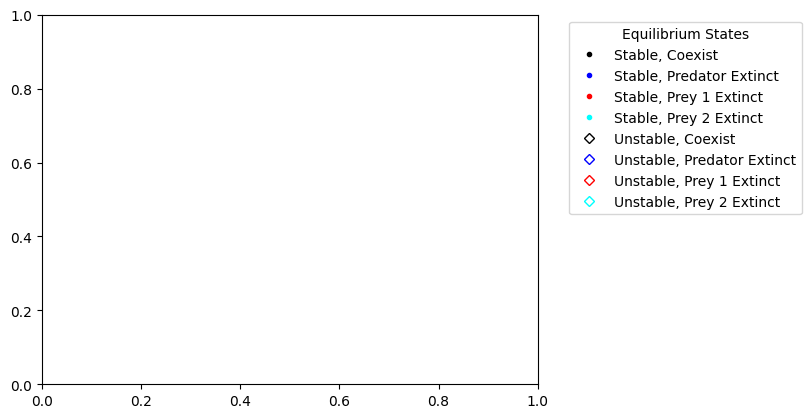

In [13]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
color_map = ['k','b','r','cyan']

stable_markers = dict(marker = "o", markersize = 3, linestyle = '')
unstable_markers = dict(marker = 'D', color='none',markersize=5, linestyle='')

legend_handles = [
    # Stable (dots)
    Line2D([0], [0], **stable_markers, color='black', label='Stable, Coexist'),
    Line2D([0], [0], **stable_markers, color='blue', label='Stable, Predator Extinct'),
    Line2D([0], [0], **stable_markers, color='red', label='Stable, Prey 1 Extinct'),
    Line2D([0], [0], **stable_markers, color='cyan', label='Stable, Prey 2 Extinct'),

    # Unstable (unfilled diamonds)
    Line2D([0], [0],  **unstable_markers, markeredgecolor='black', label='Unstable, Coexist'),
    Line2D([0], [0], **unstable_markers, markeredgecolor='blue', label='Unstable, Predator Extinct'),
    Line2D([0], [0], **unstable_markers, markeredgecolor='red', label='Unstable, Prey 1 Extinct'),
    Line2D([0], [0], **unstable_markers, markeredgecolor='cyan', label='Unstable, Prey 2 Extinct'),
]
plt.legend(handles=legend_handles, title="Equilibrium States", bbox_to_anchor=(1.05, 1), loc='upper left')


# Test Type 1, Vary Prey Growth

In [ ]:
sp, usp = get_coexistence_equilibria(
    371     param_key, param_vec,
    372     num_init, num_perturbations, perturb_strength, t_f = t_f,
    373     **params_base)

In [2]:
H = 0
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [3]:
t_f = 1100
weird_params = {'η1': np.float64(0.5), 'η2': 0.5, 'A': 0.5, 'β1': 8, 'β2': 1, 'H1': 0, 'H2': 0, 'α1_of_1': 0.05, 'α2_of_1': 0.95, 's1': 2, 's2': 2, 'α2_fun_type': 'constant', 
 'x_max': 5, 'd': 10, 'Tx': 0.01, 'pop_process': True}
initialstate = np.array([.7,.7,*initiate_g_first_x(3,weird_params["x_max"])])
coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, weird_params)
coexist_eq = np.array(coexist_eq)

/Users/taliaborofsky/Documents/CH_GroupFormation/CH_code/Functions/group_w_pop_funs.py:365: RuntimeWarning: invalid value encountered in divide
  u_ = y_/(b*y0)


In [55]:
initialstate

array([7.e-01, 7.e-01, 1.e+00, 1.e+00, 1.e+00, 1.e-04, 1.e-04])

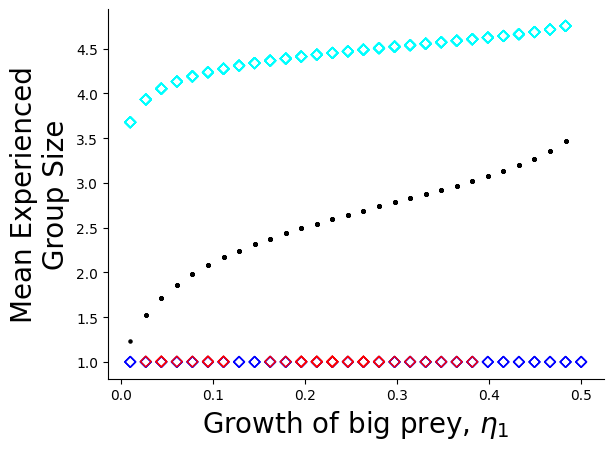

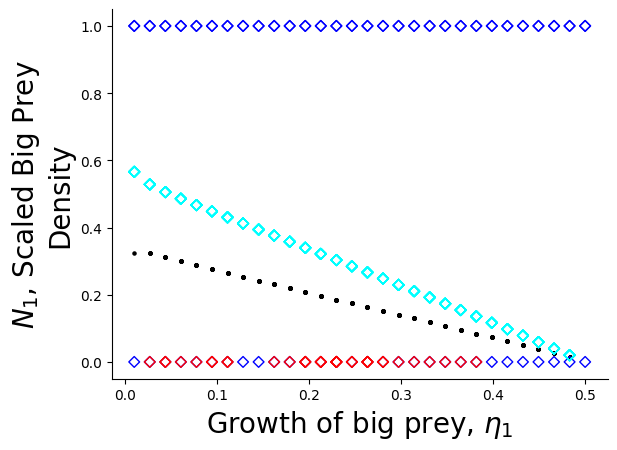

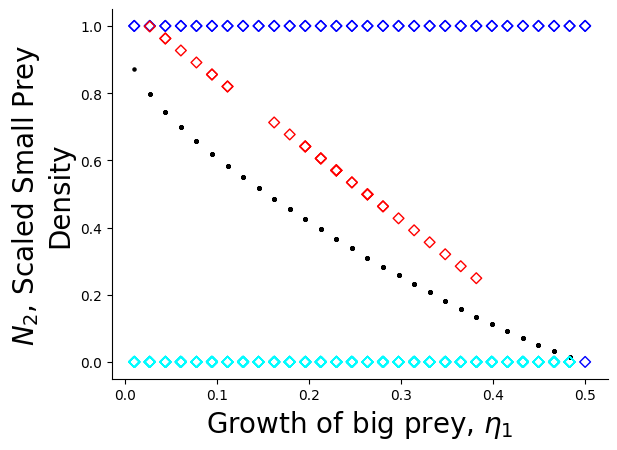

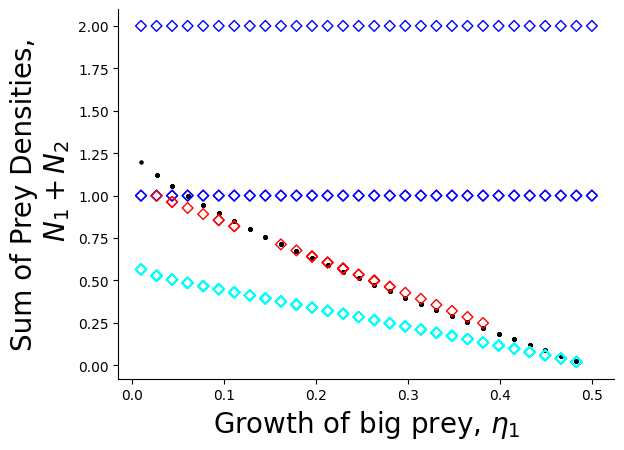

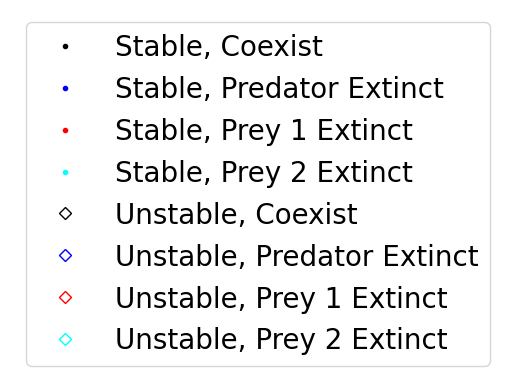

In [4]:
param_vec = np.linspace(0.01,params_base['η2'],30)
figx, figN1, figN2, figNsum, figlegend = plot_bif_diagram2(
    param_key = 'η1', 
    param_vec = param_vec, 
    params_base = params_base,
    num_init = 10, 
                      num_perturbations = 4,
                          perturb_strength = 0.02)

# Test Type II, with scale parameter

In [22]:
H = 1
x_max = 5
params_base = dict(η1 = 0.2, η2 = 0.5, A = 0.5, β1 = 8, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, d = 10,
                 Tx = .01, pop_process = True)

In [23]:
param_key = "scale"
param = 12
params = update_params(param_key,param,params_base)
t_f = 1100

initialstate = [.7,.7,*initiate_g_first_x(3,params["x_max"])]
coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, params)
coexist_eq = np.array(coexist_eq)


In [24]:
classify_and_store_equilibrium(
coexist_eq, stable_points, unstable_points, param, params
)

([],
 [[12,
   np.float64(0.42623566659864504),
   np.float64(0.643504472733688),
   np.float64(0.20980322035052312),
   np.float64(0.1722060365211732),
   np.float64(0.3096198689767072),
   np.float64(0.17497660370168425),
   np.float64(0.03116666905009455),
   np.float64(3.105846177449584)],
  [12,
   np.float64(0.42623566659864504),
   np.float64(0.643504472733688),
   np.float64(0.20980322035052312),
   np.float64(0.1722060365211732),
   np.float64(0.3096198689767072),
   np.float64(0.17497660370168425),
   np.float64(0.03116666905009455),
   np.float64(3.105846177449584)]])

In [26]:
stable_points = []; unstable_points = []
num_perturbations = 2; perturb_strength = .01
store_equilibria_and_perturb(
    param, [coexist_eq], stable_points, unstable_points,
    params, num_perturbations,
    perturb_strength
    )

([],
 [[12,
   np.float64(0.42623566659864504),
   np.float64(0.643504472733688),
   np.float64(0.20980322035052312),
   np.float64(0.1722060365211732),
   np.float64(0.3096198689767072),
   np.float64(0.17497660370168425),
   np.float64(0.03116666905009455),
   np.float64(3.105846177449584)]],
 array([[0.43159956, 0.626793  , 0.2014196 , 0.16007947, 0.31743929,
         0.1743225 , 0.03103164],
        [0.41516834, 0.64050754, 0.20216857, 0.17604059, 0.29970896,
         0.18827455, 0.01441086]]))

In [ ]:
initialstate = [.7,.7,*initiate_g_first_x(3,params["x_max"])]
params = params_base.copy()
coexist_eq, success, _ = iterate_to_eq(initialstate, t_f, params)
coexist_eq = np.array(coexist_eq)
if success:
try:
    out = store_equilibria_and_perturb(
    param, coexist_eq, stable_points, unstable_points,
    params, num_perturbations,
    perturb_strength
    )

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

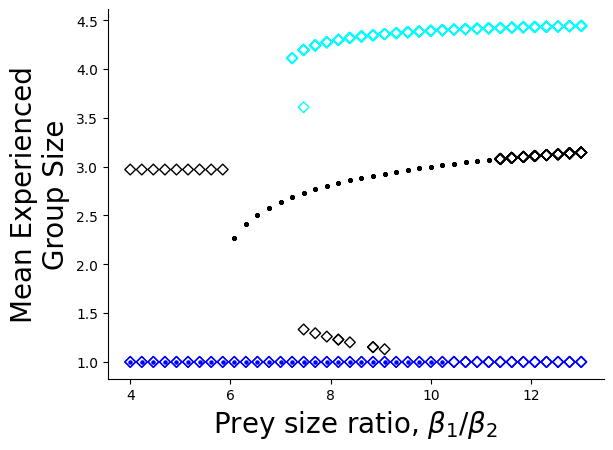

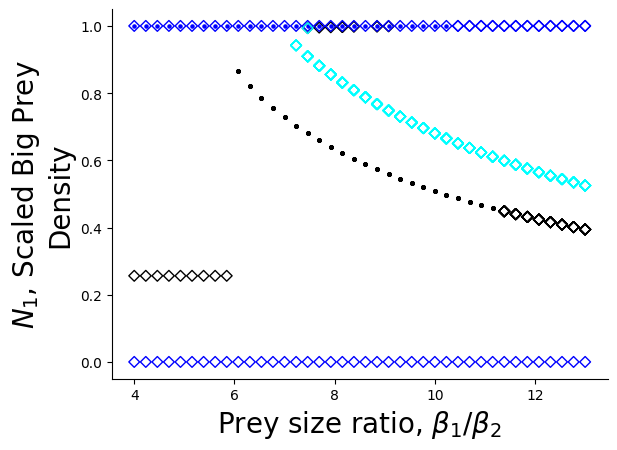

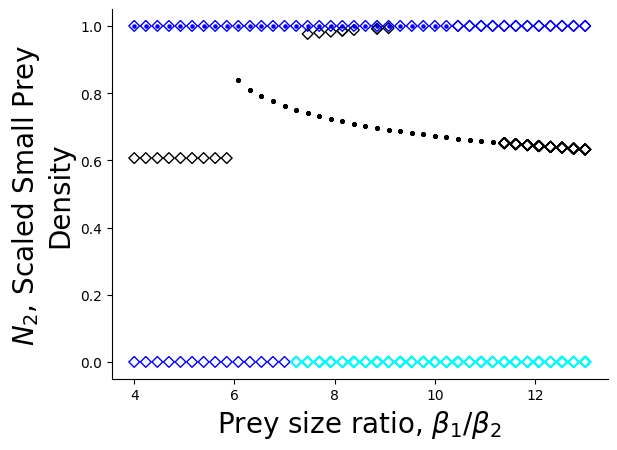

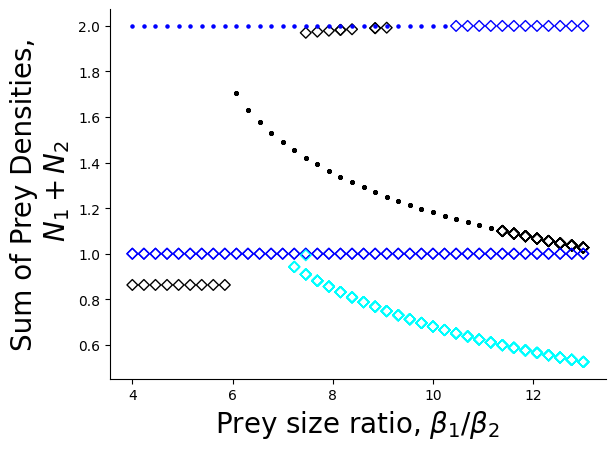

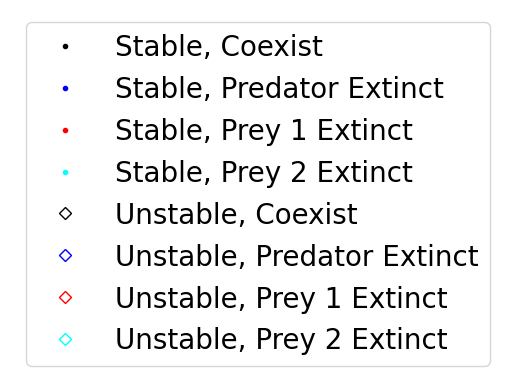

In [27]:
plot_bif_diagram2(
    param_key = "scale", param_vec = np.linspace(4,13,40), params_base = params_base,
    num_init = 10, 
                      num_perturbations = 4,
                          perturb_strength = 0.02)

In [52]:
stable_points, unstable_points = get_bif_diagram_input('scale', np.linspace(1.1,12,60),  
                          **params_base, num_init = 20, num_perturbations=3)#num_init = 10, num_perturbations=2)


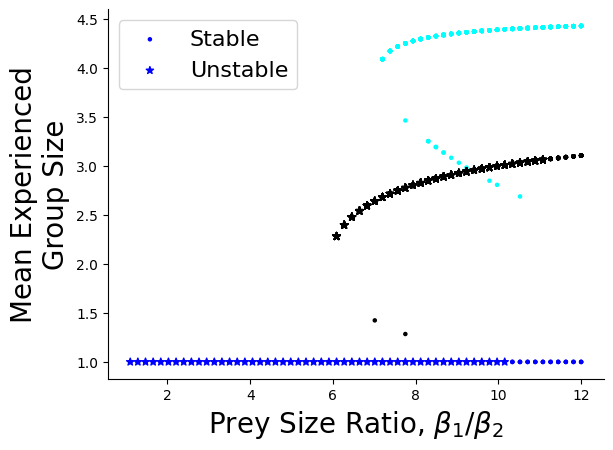

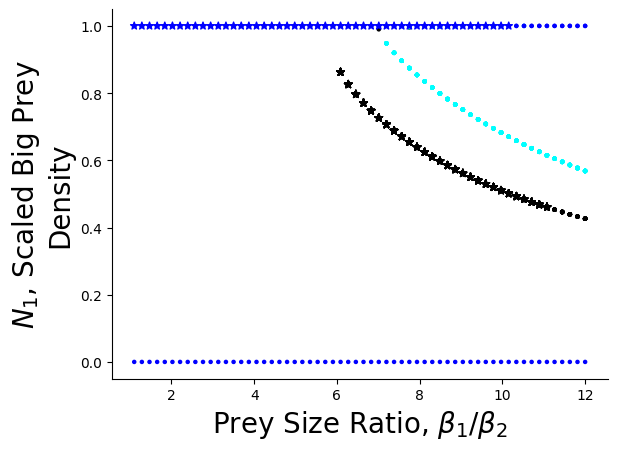

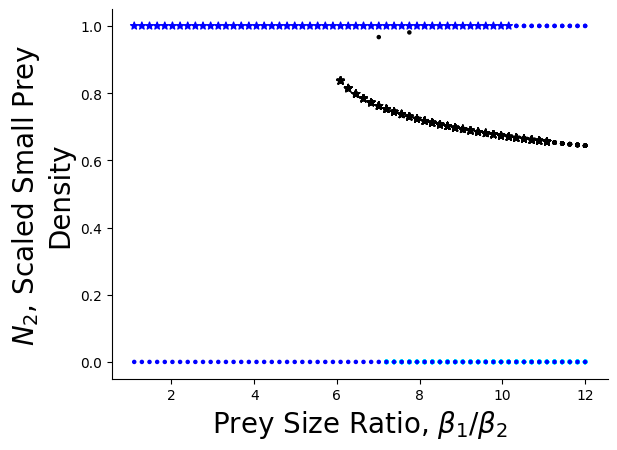

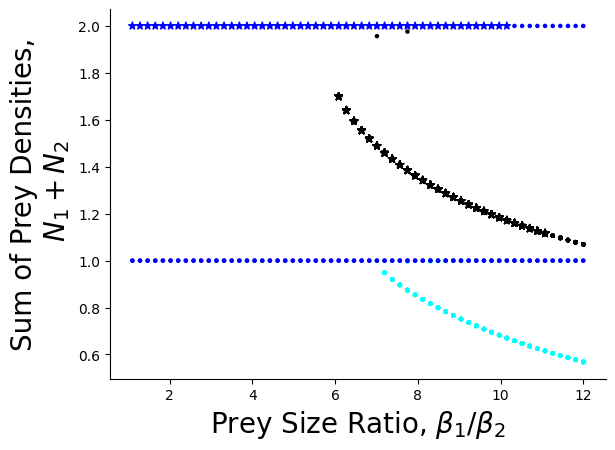

In [54]:

figx, figN1, figN2, figNsum = plot_bif_diagram(stable_points, unstable_points, 
                                      xlab = "Prey Size Ratio, " + r'$\beta_1/\beta_2$')


Signature: update_params(param_key, param, params_base)
Docstring: <no docstring>
File:      /var/folders/_4/t51wvvv53c35d1q0pv8mywxr0000gq/T/ipykernel_88423/154444673.py
Type:      function

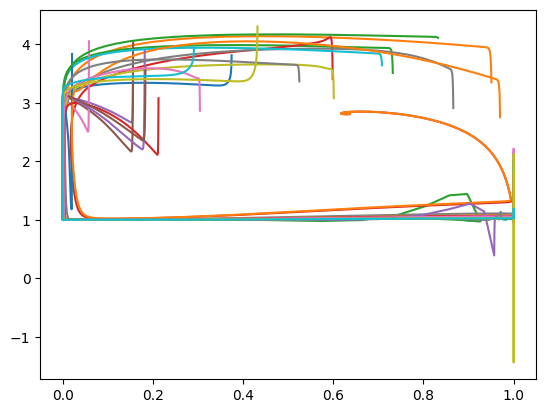

In [4]:
t_f = 1000
trajectories = []

params = update_params("scale", 8, params_base)
initial_pts = get_initial_points(20,**params.copy())
for i, init_state in enumerate(initial_pts):
    out2 = solve_ivp(full_model, [0, t_f], init_state, 
                         method = "LSODA", args = (True, params))
    results  = get_results(out2, x_max) 
    T, N1, N2, P, g_of_x_vec, mean_x = results
    plt.plot(N1, mean_x)
    trajectories.append(results)
    

In [8]:
get_equilibria_from_init_pts(initial_pts,**params)

[]

In [12]:
results = []


for i, point in enumerate(initial_pts):
    out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])

    # get the equilibrium values from the output
    sol = get_results_eq(out, x_max, tol = 1e-8)
    P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
    
    if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
        new_eq = np.array([N1_eq, N2_eq, *g_eq, mean_x_eq])
        #results.append(new_eq)
        ## append new_eq if it's unique from previous ones found
        if len(results)>0:
            for result in results:
                if np.any(np.abs(new_eq - result) > 1e-8):
                    results.append(new_eq)
        else:
            results.append(new_eq)
print(results)
                # curr_eq = new_eq

[array([0.6340475 , 0.72130594, 0.23320018, 0.15116554, 0.20782921,
       0.08853843, 0.01187339, 2.81186875])]


In [57]:
for i, traj in enumerate(trajectories):
    T, N1, N2, P, g_of_x_vec, mean_x = traj
    if np.any(mean_x <0) or np.any(np.isnan(mean_x)):
        print(i)

0
9
12
18


In [59]:
np.where(np.isnan(trajectories[9][-1]))

(array([298, 299, 300]),)

In [2]:
# old bif diagram_funs

def get_initial_points(num_initial, x_max, **params):
    ''' 
    get initial points to feed to the root finder 
    '''
    # α2_1 = params['α2_of_1']
    # α1_xm = fun_alpha1(x_max, **params)

    gx_upper = 3# try this out
    # Generate random values for N1, N2, and g(x) for each initial point
    np.random.seed(42)
    
    # N1 and N2 are between 0 and 1, not including 0
    N1_values = np.random.uniform(0.01, 1, num_initial)  # Shape: (num_initial,)
    N2_values = np.random.uniform(0.01, 1, num_initial)  # Shape: (num_initial,)
    
    # g(x) is between 0 and gx_upper for each x = 1, 2, ..., x_max
    g_values = np.random.uniform(0.01, gx_upper, (num_initial, x_max))  # Shape: (num_initial, x_max)
    # Combine N1, N2, and g(x) into a single array
    initial_points = np.hstack((N1_values[:, np.newaxis],  # Add N1 as the first column
                                N2_values[:, np.newaxis],  # Add N2 as the second column
                                g_values))  # Add g(x) as the remaining columns
    
    return initial_points

def check_unique(results, new_eq, tol_unique = 1e-8):
    '''
    checks if new_eq is in results
    new_eq in format [N1_eq, N2_eq, *g_eq, mean_x_eq]
    '''
    if len(results)>0:
        for result in results:
            if np.any(np.abs(new_eq - result) > tol_unique):
                results.append(new_eq)
    else:
        results.append(new_eq)
    return results
def get_equilibria_from_init_pts(initial_points, tol_unique=1e-8, **params):
    '''
    iterate through the initial points and see if can use root to find equilibria

    This finds coexistence equilibria!!
    '''
    x_max = params['x_max']
    #curr_eq = np.zeros(2+x_max) #N1 = 0, N2 = 0, g(x) = 0
    results = []
    for i, point in enumerate(initial_points):
        point = np.array(point)
        out = get_equilibrium(params, N1_0 = point[0], N2_0 = point[1], g_of_x_vec = point[2:])

        # get the equilibrium values from the output
        sol = get_results_eq(out, x_max, tol = 1e-8)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
        
        if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
            new_eq = np.array([N1_eq, N2_eq, *g_eq, mean_x_eq])
            results.append(new_eq)
            #results = check_unique(results, new_eq, tol_unique)
    return results
def get_perturbations(equilibrium, num, strength):
    '''
    @inputs:
    equilibrium - N1, N2, g(1), ... g(x_max)
    num - number of perturbations to return
    TO-DO
    '''

    #  initiate empty array
    perturbations = np.zeros((num, equilibrium.shape[0]))

    # fill array
    for i in range(0,num):
        #perturb
        curr_perturbed = equilibrium + strength * np.random.standard_normal(len(equilibrium))
        curr_perturbed[0:2] = np.clip(curr_perturbed[0:2], 1e-4, 1-1e-4) # make sure 0<N1,N2 <1
        curr_perturbed[2:] = np.clip(curr_perturbed[2:], a_min = 1e-8, a_max = None)
        perturbations[i,:] = curr_perturbed
    return perturbations

def classify_equilibrium(equilibrium, params):
    '''
    equilibrium = [N1, N2, *gvec]
    '''
    [N1,N2,*gvec] = equilibrium
    J = fun_Jac(N1,N2,gvec,**params)
    stability = classify_stability(J)
    return stability
    # returns "Stable (attractive)", "Unstable", "Marginally stable (needs further analysis)"
    # and "Indeterminate stability (needs further analysis)"

def classify_and_store_equilibrium(equilibrium, stable_points, unstable_points, param, params,
                                  if_add_color = True):
    '''
    given equilibrium, which is of form N1, N2, g(1), ..., g(xm), mean_x

    outputs stable_points, unstable_points
    each point in list of form [param, N1, N2, g(1), ..., g(xm), mean_x]
    '''
    if if_add_color:
        # color_i are integers signifying which type and thus used to get which color
        # get the color.. colors are ['k','b','r','cyan']
        color_i = 0 #default, coexistence
        if np.sum(equilibrium[2:-1]) < 1e-8: #predators extinct
            color_i = 1
        elif equilibrium[0]<1e-8:
            color_i = 2
        elif equilibrium[1] < 1e-8:
            color_i = 3
        result = [param, *equilibrium, color_i]
    else:
        result = [param, *equilibrium]
    
    
    stability = classify_equilibrium(equilibrium[:-1],params)
    
    if stability == "Stable (attractive)":
        stable_points.append(result)
        
    elif stability == "Unstable":
        unstable_points.append(result)
    return stable_points, unstable_points
def store_equilibria_and_perturb(param, equilibria, stable_points, unstable_points, 
                                 params, num_perturbations, perturb_strength,
                                if_add_color = True):
    '''
    @inputs:
    param - the parameter that we're at
    equilibria is list of equilibria, each of form [N1,N2, g(1), ..., g(xm)
    stable_points, unstable_points - list of stable and unstable points already found, 
    each point has its param in first entry
    params - dictionary of params
    num_perturbations - the number of perturbed points to generate
    perturb_strength - the entry-wise distance of each perturbed point from the original equilibrium
    
    iterate through equilibria found for one parameter entry, 
    classify them using classify_and_store_equilibrium, 
    and find perturbations for next iteration

    the equilibria given are from solving nullclines iwth N1!=0, N2 != 0

    @outputs
    returns stable_points, unstable_points, perturbed_pts
    stable_points and unstable_points are lists of points in form [param, N1, N2, g(1),..., g(xm), mean_x]
    perturbed_pts is list of points in form [N1, N2, g(1), g(2), ... , g(xm)
    '''

    perturbed_pts = [] # doing this just in case there are no equilibria

    # loop over each (non-extinction) equilibrium
    for equilibrium in equilibria:
        # if unique, add to equilibria vector with the param in the first entry

        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points, param, params, if_add_color)
        
        # get a few perturbations from the equilibrium to generate new points to start from --> aadd this to perturbed pts vector
        perturbed_pts = get_perturbations(np.array(equilibrium[:-1]), 
                                              num_perturbations, perturb_strength)


    return stable_points, unstable_points, perturbed_pts

def update_params(param_key, param, params_base):
    params = params_base.copy()
        
    if param_key == "scale": # this means β1/β2 = H1/H2 and β2, H2 are set
        params['β1'] = params['β2']*param
        params['H1'] = params['H2']*param
    else:
        params[param_key] = param
    return params
    
def store_pred_extinction_equilibria(stable_points, unstable_points, param, params,if_add_color = True):
    # add on predator extinction equilibria
    g_of_x_extinct = np.zeros(params['x_max'])
    pred_extinct_equilibria = [[1,1,*g_of_x_extinct,1],[1,0,*g_of_x_extinct,1],
                               [0,1,*g_of_x_extinct,1]]

    # now add on prey extinction equilibria
            # TO-DO
    # First big prey extinct

    for equilibrium in pred_extinct_equilibria:
        
        stable_points, unstable_points = classify_and_store_equilibrium(equilibrium, stable_points, 
                                                                        unstable_points, param, params, 
                                                                        if_add_color = if_add_color)
    return stable_points, unstable_points



def get_bif_diagram_input(param_key, param_vec, num_init = 30, num_perturbations = 2,
                          perturb_strength = 0.01, 
                          **params_base):
    '''
    for a parameter that's varied, finds the equilibria and their stability
    '''
    # initiate empty vectors to be filled
    
    # initiate empty perturbed_pts vector, containing points perturbed from the last set of equilibria
    perturbed_pts = np.array([]).reshape(0,2 + params_base['x_max'])
    
    #initiate empty vectors for stable and unstable pints
    stable_points = []
    unstable_points = []

    for param in param_vec:
        # update param dictionary.
        params = update_params(param_key, param, params_base)
    
        # get some random initial points
        init_pts = get_initial_points(num_initial=num_init,**params.copy())
        init_pts = np.vstack((init_pts,perturbed_pts))
        
        # find equilibria starting from initialpoints and perturbed_pts. already checked for uniqueness
        # each row has N1, N2, g(1), .. g(x_max), \bar{x}
        coexist_equilibria = get_equilibria_from_init_pts(init_pts, **params.copy())

        # add big prey extinct equilibria 
        coexist_and_big_prey_extinct_equilibria = get_equilibria_from_init_pts_i_extinct(
            coexist_equilibria, init_pts,1,**params.copy()
        )
        # add small prey extinct equilibria using initpts 
        pred_not_extinct_equilibria = get_equilibria_from_init_pts_i_extinct(
            coexist_and_big_prey_extinct_equilibria, init_pts,2,**params.copy()
        )

        # below with this new big list
        
        if np.size(pred_not_extinct_equilibria) > 0:
            out = store_equilibria_and_perturb(
                param, pred_not_extinct_equilibria, stable_points, unstable_points, 
                                           params, num_perturbations, perturb_strength
            )
            stable_points, unstable_points, perturbed_pts  = out
            
        stable_points, unstable_points = store_pred_extinction_equilibria(
                                        stable_points, unstable_points, 
                                        param, params
        )
    
    # Convert to numpy arrays for easier manipulation
    stable_points = np.array(stable_points)
    unstable_points = np.array(unstable_points)
    return stable_points, unstable_points


def plot_bif_diagram(stable_points, unstable_points, xlab):
    '''
    using the output from get_bif_diagram_input, plots a bifurcation diagram
    '''
    figx, axx = plt.subplots(1,1)
    figN1, axN1 = plt.subplots(1,1)
    figN2, axN2 = plt.subplots(1,1)
    figNsum, axNsum = plt.subplots(1,1)

    stable_markers = dict(label = "Stable", marker = "o", s = 5)
    unstable_markers = dict(label = "Unstable", marker = "*", s = 30)

    colormap = ['k','b','r','cyan']
    for markers, points in zip([stable_markers, unstable_markers],
                               [unstable_points, stable_points]):
        if points.size > 0:
            paramvec = points[:,0]
            N1 = np.array(points[:,1])
            N2 = np.array(points[:,2])
            meanx = points[:,-2]
            colors_i = np.array(points[:,-1]).astype(int)
            colors = [colormap[color_i] for color_i in colors_i]
            axN1.scatter(paramvec, N1,
                     **markers, c = colors)
            axN2.scatter(paramvec, N2,  
                     **markers, c = colors)
            axx.scatter(paramvec, meanx, 
                    **markers, c = colors)
            axNsum.scatter(paramvec, N1+N2, 
                       **markers, c = colors)
    # if unstable_points.size > 0:
    #     paramvec = unstable_points[:,0]
    #     N1 = np.array(unstable_points[:, 1])
    #     N2 = np.array(unstable_points[:,2])
    #     meanx = unstable_points[:,-2]
    #     colors = unstable_points[:,-1]
    #     axN1.scatter(paramvec, N1,
    #                  **unstable_markers)
    #     axN2.scatter(paramvec, N2,  
    #                  **unstable_markers)
    #     axx.scatter(paramvec, meanx, 
    #                 **unstable_markers)
    #     axNsum.scatter(paramvec, N1+N2, 
    #                    **unstable_markers)
    # if stable_points.size > 0:
    #     paramvec = stable_points[:,0]
    #     N1 = np.array(stable_points[:, 1])
    #     N2 = np.array(stable_points[:,2])
    #     meanx = stable_points[:,-2]
        
    #     axN1.scatter(paramvec, N1, **stable_markers)
    #     axN2.scatter(paramvec, N2, **stable_markers)
    #     axx.scatter(paramvec, meanx, **stable_markers)
    #     axNsum.scatter(paramvec, N1+N2, **stable_markers)
    

    
    Nsumlab = "Sum of Prey Densities,\n "+r'$N_1 + N_2$'
    for ax, ylab in zip([axx, axN1, axN2, axNsum],
                        [mean_x_lab, N1lab, N2lab,
                        Nsumlab]):
        if_legend = ylab == mean_x_lab 
        format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = if_legend,
             ncol_legend = 1)
    return figx, figN1, figN2, figNsum
def get_equilibria_from_init_pts_i_extinct(results, initial_points, i, tol_unique = 1e-8, **params):
    '''
    iterate through the initial points and see if can use root to find equilibria
    prey i (1 or 2) extinct
    I need to ignore the first column from the initial points
    append to results if found an equilibrium

    This finds coexistence equilibria!!
    '''
    x_max = params['x_max']
    curr_eq = np.zeros(2+x_max) #N1 = 0, N2 = 0, g(x) = 0
    
    for point in initial_points:
        out = get_equilibrium_prey_i_extinct(params, i, Nj_0 = point[1], 
                                             g_of_x_vec = point[2:])

        # get the equilibrium values from the output
        sol = get_results_eq(out, x_max, tol = 1e-8, which_prey_extinct = i)
        P_eq, N1_eq, N2_eq, g_eq, mean_x_eq, success = sol 
        
        if success: # the root finder found an equilibrium and it's "valid" (N1, N2, g(x) are in their ranges)
            new_eq = np.array([N1_eq, N2_eq, *g_eq, mean_x_eq])

            # append new_eq if it's unique from the last one
            #results = check_unique(results, new_eq, tol_unique)
            results.append(new_eq)

    return results